# Project Objective

This notebook aims to prepare and explore the `emi_prediction_dataset.csv` to support building a reliable model for predicting EMI (Equated Monthly Installment) eligibility.

Goals:
- Perform exploratory data analysis to understand distributions, missingness, and relationships between features and the target `emi_eligibility`.
- Clean and normalize raw fields (fix types, remove formatting issues), impute missing values, and encode categorical variables.
- Create robust feature engineering to capture affordability and repayment capacity (e.g. debt ratios, net income after expenses).
- Produce a reproducible preprocessing pipeline that can be reused for modeling and inference.

Deliverables from this notebook:
- Cleaned and typed dataset ready for modeling.
- A documented preprocessing pipeline (transformations, imputations, encodings).
- Summary EDA plots and tables describing key predictors and data quality issues.

Assumptions & Notes:
- The data contains inconsistent string/number formats (e.g. `monthly_salary`, `bank_balance`, `age`) and missing values; these will be corrected and imputed.
- Class balance for `emi_eligibility` will be checked and handled during modeling in downstream notebooks.

Next steps: finalize preprocessing, persist the cleaned dataset, and move to model training and evaluation notebooks.

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [147]:
emi_pred=pd.read_csv("files\\emi_prediction_dataset.csv", low_memory=False)

In [148]:
emi_pred.head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0


In [149]:
emi_pred.shape

(404800, 27)

In [150]:
emi_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     404800 non-null  object 
 1   gender                  404800 non-null  object 
 2   marital_status          404800 non-null  object 
 3   education               402396 non-null  object 
 4   monthly_salary          404800 non-null  object 
 5   employment_type         404800 non-null  object 
 6   years_of_employment     404800 non-null  float64
 7   company_type            404800 non-null  object 
 8   house_type              404800 non-null  object 
 9   monthly_rent            402374 non-null  float64
 10  family_size             404800 non-null  int64  
 11  dependents              404800 non-null  int64  
 12  school_fees             404800 non-null  float64
 13  college_fees            404800 non-null  float64
 14  travel_expenses     

In [151]:
emi_pred.columns

Index(['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure', 'emi_eligibility',
       'max_monthly_emi'],
      dtype='object')

In [152]:
col_x=['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure']

In [153]:
emi_pred["emi_eligibility"].value_counts()

emi_eligibility
Not_Eligible    312868
Eligible         74444
High_Risk        17488
Name: count, dtype: int64

In [154]:
emi_pred[emi_pred["emi_eligibility"]=="Not_Eligible"].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
4,48,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0
5,38,Male,Married,High School,38800.0,Government,5.0,Large Indian,Rented,13500.0,...,No,0.0,792.0,260800.0,55600.0,Vehicle EMI,1257000.0,53,Not_Eligible,500.0
6,58,Male,Single,High School,27100.0,Private,36.0,Large Indian,Own,0.0,...,No,0.0,741.0,68000.0,36200.0,Home Appliances EMI,280000.0,11,Not_Eligible,1950.0


In [155]:
emi_pred[emi_pred["emi_eligibility"]=="Eligible"].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
2,38,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
12,32,male,Married,Graduate,11837.0,Private,1.3,Large Indian,Rented,11700.0,...,No,0.0,695.0,129600.0,70900.0,E-commerce Shopping EMI,30000.0,12,Eligible,13440.0
14,27,Female,Married,Post Graduate,110800.0,Government,0.5,MNC,Family,0.0,...,No,0.0,788.0,157300.0,40500.0,E-commerce Shopping EMI,83000.0,21,Eligible,27360.0
21,27,Female,Single,Post Graduate,67300.0,Government,0.8,MNC,Rented,16400.0,...,No,0.0,765.0,448600.0,142800.0,Education EMI,226000.0,36,Eligible,13002.0


In [156]:
emi_pred.isna().sum()

age                          0
gender                       0
marital_status               0
education                 2404
monthly_salary               0
employment_type              0
years_of_employment          0
company_type                 0
house_type                   0
monthly_rent              2426
family_size                  0
dependents                   0
school_fees                  0
college_fees                 0
travel_expenses              0
groceries_utilities          0
other_monthly_expenses       0
existing_loans               0
current_emi_amount           0
credit_score              2420
bank_balance              2426
emergency_fund            2351
emi_scenario                 0
requested_amount             0
requested_tenure             0
emi_eligibility              0
max_monthly_emi              0
dtype: int64

In [157]:
emi_pred[emi_pred["education"].isna()].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
111,38,Female,Married,NaN,46100.0,Private,3.4,MNC,Own,0.0,...,No,0.0,730.0,308200.0,88800.0,Vehicle EMI,126000.0,58,Eligible,6985.0
426,38,Female,Married,NaN,15000.0,Government,4.2,MNC,Family,0.0,...,No,0.0,752.0,112200.0,55800.0,Home Appliances EMI,280000.0,12,Not_Eligible,500.0
455,48,Male,Married,NaN,53200.0,Private,3.4,Small,Rented,15800.0,...,No,0.0,630.0,298700.0,141600.0,Vehicle EMI,1000000.0,54,Not_Eligible,500.0
593,48,Female,Married,NaN,42300.0,Self-employed,15.6,Large Indian,Family,0.0,...,No,0.0,753.0,267900.0,112000.0,Home Appliances EMI,233000.0,20,High_Risk,14374.8
773,32,Female,Single,NaN,46100.0,Private,10.0,Large Indian,Rented,11400.0,...,No,0.0,735.0,68800.0,38500.0,E-commerce Shopping EMI,141000.0,7,Not_Eligible,6120.0


In [158]:
emi_pred["education"].value_counts()

education
Graduate         181015
Post Graduate    100314
High School       60732
Professional      60335
Name: count, dtype: int64

In [159]:
emi_pred[emi_pred["monthly_rent"].isna()].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
116,38,Male,Married,Graduate,20000.0,Private,2.1,Large Indian,Own,NaN,...,No,0.0,748.0,18400.0,9500.0,Vehicle EMI,238000.0,69,Not_Eligible,500.0
183,48,Male,Married,Post Graduate,111000.0,Private,1.7,Large Indian,Rented,NaN,...,No,0.0,803.0,98300.0,29200.0,Education EMI,311000.0,24,Eligible,20160.0
226,58,Male,Married,Graduate,85400.0,Private,7.1,Large Indian,Family,NaN,...,Yes,14800.0,661.0,241900.0,59400.0,Vehicle EMI,103000.0,83,Eligible,8015.0
429,48,Male,Married,High School,49500.0,Private,26.0,Large Indian,Own,NaN,...,No,0.0,690.0,123700.0,64200.0,Education EMI,466000.0,8,Not_Eligible,15150.0
638,27,Male,Single,Graduate,34500.0,Private,1.1,Large Indian,Own,NaN,...,No,0.0,596.0,224300.0,61900.0,Home Appliances EMI,122000.0,17,High_Risk,9416.0


In [160]:
emi_pred[emi_pred["credit_score"].isna()].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
154,27,Male,Married,Professional,63700.0,Private,4.2,MNC,Own,7917.0,...,Yes,16700.0,NaN,320700.0,173600.0,Home Appliances EMI,103000.0,7,Not_Eligible,3955.0
619,48,Female,Married,Graduate,18700.0,Government,3.6,Small,Rented,3100.0,...,Yes,3700.0,NaN,16000.0,5200.0,Vehicle EMI,1468000.0,67,Not_Eligible,862.4
693,38,Male,Married,Professional,30000.0,Private,0.5,MNC,Rented,8200.0,...,No,0.0,NaN,107900.0,31500.0,Vehicle EMI,1130000.0,19,Not_Eligible,500.0
739,38,Male,Married,Post Graduate,65900.0,Government,1.6,Mid-size,Rented,11800.0,...,No,0.0,NaN,353300.0,172800.0,Vehicle EMI,88000.0,47,Not_Eligible,650.0
796,38,Male,Married,Post Graduate,51900.0,Private,5.8,Large Indian,Family,0.0,...,No,0.0,NaN,280000.0,134200.0,Home Appliances EMI,91000.0,21,Eligible,11750.0


In [161]:
emi_pred[emi_pred["bank_balance"].isna()].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
136,32,Female,Single,Graduate,41500.0,Private,1.1,Mid-size,Own,0.0,...,Yes,9800.0,656.0,NaN,86700.0,E-commerce Shopping EMI,129000.0,5,Not_Eligible,980.0
298,27,Female,Married,Post Graduate,92400.0,Private,0.5,Large Indian,Family,0.0,...,Yes,13200.0,677.0,NaN,275900.0,Personal Loan EMI,935000.0,41,Not_Eligible,6608.0
700,48,Male,Married,Post Graduate,114900.0,Private,20.5,MNC,Family,0.0,...,No,0.0,632.0,NaN,70600.0,Personal Loan EMI,543000.0,46,High_Risk,17088.0
1010,38,Male,Single,High School,30900.0,Private,3.4,MNC,Rented,7600.0,...,No,0.0,703.0,NaN,25100.0,Home Appliances EMI,204000.0,34,Not_Eligible,6350.0
1090,38,Male,Married,Graduate,40800.0,Government,2.2,Mid-size,Own,0.0,...,Yes,6200.0,728.0,NaN,66400.0,Vehicle EMI,1347000.0,26,Not_Eligible,6737.5


In [162]:
emi_pred[emi_pred["emergency_fund"].isna()].head()

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
237,38,Male,Married,Graduate,56500.0,Private,2.9,Large Indian,Rented,11500.0,...,No,0.0,676.0,325900.0,NaN,E-commerce Shopping EMI,81000.0,19,Eligible,10050.0
267,48,Male,Married,Graduate,46800.0,Private,0.6,Large Indian,Family,0.0,...,Yes,12000.0,654.0,229600.0,NaN,Personal Loan EMI,199000.0,33,Not_Eligible,500.0
347,32,Male,Married,Graduate,97500.0,Private,2.2,Startup,Own,0.0,...,No,0.0,707.0,767800.0,NaN,E-commerce Shopping EMI,95000.0,14,Eligible,22440.0
879,48,Female,Married,Graduate,36100.0,Private,4.7,MNC,Family,0.0,...,Yes,7400.0,639.0,45900.0,NaN,Home Appliances EMI,150000.0,12,Not_Eligible,2172.8
923,27,Male,Single,Post Graduate,67000.0,Government,0.5,MNC,Rented,21500.0,...,No,0.0,705.0,347900.0,NaN,E-commerce Shopping EMI,164000.0,11,Not_Eligible,10900.0


In [163]:
emi_pred.dtypes

age                        object
gender                     object
marital_status             object
education                  object
monthly_salary             object
employment_type            object
years_of_employment       float64
company_type               object
house_type                 object
monthly_rent              float64
family_size                 int64
dependents                  int64
school_fees               float64
college_fees              float64
travel_expenses           float64
groceries_utilities       float64
other_monthly_expenses    float64
existing_loans             object
current_emi_amount        float64
credit_score              float64
bank_balance               object
emergency_fund            float64
emi_scenario               object
requested_amount          float64
requested_tenure            int64
emi_eligibility            object
max_monthly_emi           float64
dtype: object

In [164]:
emi_pred[emi_pred["bank_balance"].isna()]

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
136,32,Female,Single,Graduate,41500.0,Private,1.1,Mid-size,Own,0.0,...,Yes,9800.0,656.0,NaN,86700.0,E-commerce Shopping EMI,129000.0,5,Not_Eligible,980.0
298,27,Female,Married,Post Graduate,92400.0,Private,0.5,Large Indian,Family,0.0,...,Yes,13200.0,677.0,NaN,275900.0,Personal Loan EMI,935000.0,41,Not_Eligible,6608.0
700,48,Male,Married,Post Graduate,114900.0,Private,20.5,MNC,Family,0.0,...,No,0.0,632.0,NaN,70600.0,Personal Loan EMI,543000.0,46,High_Risk,17088.0
1010,38,Male,Single,High School,30900.0,Private,3.4,MNC,Rented,7600.0,...,No,0.0,703.0,NaN,25100.0,Home Appliances EMI,204000.0,34,Not_Eligible,6350.0
1090,38,Male,Married,Graduate,40800.0,Government,2.2,Mid-size,Own,0.0,...,Yes,6200.0,728.0,NaN,66400.0,Vehicle EMI,1347000.0,26,Not_Eligible,6737.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403835,38,Male,Married,Graduate,44900.0,Private,10.6,MNC,Family,0.0,...,Yes,8100.0,808.0,NaN,121900.0,Home Appliances EMI,219000.0,22,Not_Eligible,4032.0
403944,32,Male,Single,Post Graduate,118700.0,Private,0.5,Startup,Own,0.0,...,No,0.0,746.0,NaN,106700.0,Vehicle EMI,1003000.0,76,Eligible,31640.0
404092,48,Female,Married,Professional,47400.0,Private,2.5,MNC,Own,0.0,...,Yes,7400.0,569.0,NaN,8900.0,Vehicle EMI,204000.0,68,Not_Eligible,3628.8
404495,38,Male,Married,High School,33100.0,Government,12.0,Mid-size,Own,0.0,...,No,0.0,798.0,NaN,62800.0,E-commerce Shopping EMI,132000.0,7,Not_Eligible,8712.0


In [165]:
emi_pred[pd.notna(emi_pred["bank_balance"])==False]

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
136,32,Female,Single,Graduate,41500.0,Private,1.1,Mid-size,Own,0.0,...,Yes,9800.0,656.0,NaN,86700.0,E-commerce Shopping EMI,129000.0,5,Not_Eligible,980.0
298,27,Female,Married,Post Graduate,92400.0,Private,0.5,Large Indian,Family,0.0,...,Yes,13200.0,677.0,NaN,275900.0,Personal Loan EMI,935000.0,41,Not_Eligible,6608.0
700,48,Male,Married,Post Graduate,114900.0,Private,20.5,MNC,Family,0.0,...,No,0.0,632.0,NaN,70600.0,Personal Loan EMI,543000.0,46,High_Risk,17088.0
1010,38,Male,Single,High School,30900.0,Private,3.4,MNC,Rented,7600.0,...,No,0.0,703.0,NaN,25100.0,Home Appliances EMI,204000.0,34,Not_Eligible,6350.0
1090,38,Male,Married,Graduate,40800.0,Government,2.2,Mid-size,Own,0.0,...,Yes,6200.0,728.0,NaN,66400.0,Vehicle EMI,1347000.0,26,Not_Eligible,6737.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403835,38,Male,Married,Graduate,44900.0,Private,10.6,MNC,Family,0.0,...,Yes,8100.0,808.0,NaN,121900.0,Home Appliances EMI,219000.0,22,Not_Eligible,4032.0
403944,32,Male,Single,Post Graduate,118700.0,Private,0.5,Startup,Own,0.0,...,No,0.0,746.0,NaN,106700.0,Vehicle EMI,1003000.0,76,Eligible,31640.0
404092,48,Female,Married,Professional,47400.0,Private,2.5,MNC,Own,0.0,...,Yes,7400.0,569.0,NaN,8900.0,Vehicle EMI,204000.0,68,Not_Eligible,3628.8
404495,38,Male,Married,High School,33100.0,Government,12.0,Mid-size,Own,0.0,...,No,0.0,798.0,NaN,62800.0,E-commerce Shopping EMI,132000.0,7,Not_Eligible,8712.0


In [166]:
def type_corrector(x):
    # Skip if x is NaN
    if pd.isna(x):
        return np.nan
    # Convert safely to string and handle decimals
    try:
        return int(float(str(x).split(".")[0]))
    except ValueError:
        return np.nan

In [167]:
# Montlhly salary should be in int or float but showing in object type. So converting it to int type. there are multiple ". ." observed in the data so removing that also.

emi_pred["monthly_salary"] = emi_pred["monthly_salary"].apply(type_corrector)

In [168]:
emi_pred["bank_balance"] = emi_pred["bank_balance"].apply(type_corrector)

In [169]:
emi_pred["age"] = emi_pred["age"].apply(type_corrector)

In [170]:
emi_pred.dtypes

age                         int64
gender                     object
marital_status             object
education                  object
monthly_salary              int64
employment_type            object
years_of_employment       float64
company_type               object
house_type                 object
monthly_rent              float64
family_size                 int64
dependents                  int64
school_fees               float64
college_fees              float64
travel_expenses           float64
groceries_utilities       float64
other_monthly_expenses    float64
existing_loans             object
current_emi_amount        float64
credit_score              float64
bank_balance              float64
emergency_fund            float64
emi_scenario               object
requested_amount          float64
requested_tenure            int64
emi_eligibility            object
max_monthly_emi           float64
dtype: object

In [171]:
x_data=emi_pred[col_x].copy()

In [172]:
emi_pred

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38,Female,Married,Professional,82600,Private,0.9,Mid-size,Rented,20000.0,...,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.0
1,38,Female,Married,Graduate,21500,Private,7.0,MNC,Family,0.0,...,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.0
2,38,Male,Married,Professional,86100,Private,5.8,Startup,Own,0.0,...,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.0
3,58,Female,Married,High School,66800,Private,2.2,Mid-size,Own,0.0,...,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.0
4,48,Female,Married,Professional,57300,Private,3.4,Mid-size,Family,0.0,...,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27,Male,Married,Graduate,32400,Private,5.0,Large Indian,Rented,10400.0,...,No,0.0,649.0,62000.0,32600.0,Personal Loan EMI,506000.0,47,Not_Eligible,500.0
404796,38,Male,Married,Post Graduate,49200,Private,1.9,MNC,Own,0.0,...,No,0.0,712.0,142200.0,38100.0,Personal Loan EMI,708000.0,33,Not_Eligible,5200.0
404797,32,Male,Single,Graduate,25700,Private,3.2,MNC,Rented,6300.0,...,No,0.0,676.0,191600.0,39700.0,Home Appliances EMI,93000.0,21,High_Risk,5665.0
404798,48,Male,Married,Graduate,47200,Private,3.0,MNC,Own,0.0,...,No,0.0,784.0,170400.0,45600.0,Home Appliances EMI,144000.0,36,Eligible,14460.0


In [173]:
# Formatting string columns to have consistent capitalization and removing leading/trailing spaces
x_data[x_data.select_dtypes(include=['object']).columns]=x_data[x_data.select_dtypes(include=['object']).columns].apply(lambda x: x.str.strip().str.title())

In [174]:
x_data.select_dtypes(include=['object']).columns

Index(['gender', 'marital_status', 'education', 'employment_type',
       'company_type', 'house_type', 'existing_loans', 'emi_scenario'],
      dtype='object')

In [175]:
numeric_cols=x_data.select_dtypes(include=['int64', 'float64']).columns

In [176]:
x_data.nunique()

age                          15
gender                        4
marital_status                2
education                     4
monthly_salary            12822
employment_type               3
years_of_employment         356
company_type                  5
house_type                    3
monthly_rent               4396
family_size                   5
dependents                    5
school_fees                 132
college_fees                202
travel_expenses             284
groceries_utilities         544
other_monthly_expenses      373
existing_loans                2
current_emi_amount          508
credit_score                427
bank_balance              10623
emergency_fund             5486
emi_scenario                  5
requested_amount           1491
requested_tenure             82
dtype: int64

In [177]:
x_data.replace({"existing_loans":{"Yes":1, "No":0}}, inplace=True)

In [178]:
x_data.replace({"marital_status":{"Married":1, "Single":0}}, inplace=True)

In [179]:
x_data["gender"].value_counts()

gender
Male      241107
Female    160679
M           1843
F           1171
Name: count, dtype: int64

In [180]:
x_data.replace({"gender":{"M":1, "F":0, "Male":1, "Female":0}}, inplace=True)

In [181]:
x_data["gender"].value_counts()

gender
1    242950
0    161850
Name: count, dtype: int64

In [182]:
x_data["emi_scenario"].value_counts()

emi_scenario
Home Appliances Emi        80988
Personal Loan Emi          80980
E-Commerce Shopping Emi    80948
Education Emi              80942
Vehicle Emi                80942
Name: count, dtype: int64

### Categorical VS Categorical Association Test Chi2 Test

In [183]:
pd.crosstab(x_data["gender"], x_data["emi_scenario"])

emi_scenario,E-Commerce Shopping Emi,Education Emi,Home Appliances Emi,Personal Loan Emi,Vehicle Emi
gender,,,,,
0,32514,32250,32363,32097,32626
1,48434,48692,48625,48883,48316


In [184]:
def chi_test(col: list, x_data=x_data):
    from scipy.stats import chi2_contingency
    data=pd.DataFrame()
    col1, col2 =[], []
    chi2, p, dof, expected = [], [], [], []
    col_vs_col = []
    for i in col:
        for j in col:
            if i != j:
                contingency_table = pd.crosstab(x_data[i], x_data[j])
                chi2_stat, p_value, dof_val, expected_val = chi2_contingency(contingency_table)
                col1.append(f"{i}")
                col2.append(f"{j}")
                col_vs_col.append( f"{i} VS {j}")
                chi2.append(chi2_stat)
                p.append(p_value)
                dof.append(dof_val)
                expected.append(expected_val)
    data=pd.DataFrame({"Col1": col1, "Col2": col2,"Columns":col_vs_col,
                       "Chi2_statistic":chi2,
                          "p_value":p,
                            "Degrees_of_freedom":dof,
                                "Expected_freq":expected})
    return data



In [185]:
def chi_test_optimized(cat_cols: list, x_data):
    from scipy.stats import chi2_contingency
    import pandas as pd
    import numpy as np
    from itertools import combinations

    # Store results
    results = []

    # Loop through unique pairs only (no A vs B and B vs A duplicates)
    for col1, col2 in combinations(cat_cols, 2):
        # Create contingency table
        contingency_table = pd.crosstab(x_data[col1], x_data[col2])

        # Skip if table is empty or invalid
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            continue

        try:
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        except ValueError:
            continue  # skip columns with NaN or invalid values

        # Append results
        results.append({
            "Col1": col1,
            "Col2": col2,
            "Columns": f"{col1} VS {col2}",
            "Chi2_statistic": chi2_stat,
            "p_value": p_value,
            "Degrees_of_freedom": dof,
            "Expected_freq": expected
        })

    # Convert to DataFrame
    chi_result = pd.DataFrame(results)

    # Optional: add significance and strength of relationship (Cramér’s V)
    chi_result["Significant"] = np.where(chi_result["p_value"] < 0.05, "Yes", "No")
    chi_result["Cramers_V"] = np.sqrt(
        chi_result["Chi2_statistic"] / 
        (len(x_data) * (np.minimum(
            chi_result["Degrees_of_freedom"], chi_result["Degrees_of_freedom"].max())))
    )

    # Sort by strongest relationships
    chi_result = chi_result.sort_values(by="Chi2_statistic", ascending=False).reset_index(drop=True)

    return chi_result


In [186]:
emi_pred.columns

Index(['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure', 'emi_eligibility',
       'max_monthly_emi'],
      dtype='object')

In [187]:
emi_pred_new=x_data.copy()
emi_pred_new[['emi_eligibility', 'max_monthly_emi']]=emi_pred[['emi_eligibility', 'max_monthly_emi']]

In [188]:
emi_pred_new.head(1)

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38,0,1,Professional,82600,Private,0.9,Mid-Size,Rented,20000.0,...,1,23700.0,660.0,303200.0,70200.0,Personal Loan Emi,850000.0,15,Not_Eligible,500.0


In [189]:
emi_pred["emi_scenario"].value_counts()

emi_scenario
Home Appliances EMI        80988
Personal Loan EMI          80980
E-commerce Shopping EMI    80948
Education EMI              80942
Vehicle EMI                80942
Name: count, dtype: int64

In [190]:
emi_pred.select_dtypes(include=['object']).head(2)

,gender,marital_status,education,employment_type,company_type,house_type,existing_loans,emi_scenario,emi_eligibility
0,Female,Married,Professional,Private,Mid-size,Rented,Yes,Personal Loan EMI,Not_Eligible
1,Female,Married,Graduate,Private,MNC,Family,Yes,E-commerce Shopping EMI,Not_Eligible


In [191]:
categorical_columns = [
    'gender', 'marital_status', 'education', 'employment_type', 'company_type', 'house_type','emi_eligibility','existing_loans','emi_scenario'
]

In [192]:
chi_result=chi_test(categorical_columns, x_data=emi_pred_new)

In [193]:
chi_result[chi_result["p_value"]<0.05]

,Col1,Col2,Columns,Chi2_statistic,p_value,Degrees_of_freedom,Expected_freq
12,marital_status,house_type,marital_status VS house_type,6.217321,4.466074e-02,2,"[[24166.973804347825, 34087.23725543478, 38708..."
13,marital_status,emi_eligibility,marital_status VS emi_eligibility,539.226137,8.100880e-118,2,"[[17831.802302371543, 4188.954901185771, 74942..."
21,education,emi_eligibility,education VS emi_eligibility,8007.792882,0.000000e+00,6,"[[33291.976361594054, 7818.27031083808, 139904..."
29,employment_type,emi_eligibility,employment_type VS emi_eligibility,707.252428,9.372541e-152,4,"[[14926.867954545454, 3506.5427272727275, 6273..."
41,house_type,marital_status,house_type VS marital_status,6.217321,4.466074e-02,2,"[[24166.973804347825, 76725.02619565217], [340..."
45,house_type,emi_eligibility,house_type VS emi_eligibility,16866.428013,0.000000e+00,4,"[[18554.357826086958, 4358.6939130434785, 7797..."
49,emi_eligibility,marital_status,emi_eligibility VS marital_status,539.226137,8.100880e-118,2,"[[17831.802302371543, 56612.19769762846], [418..."
50,emi_eligibility,education,emi_eligibility VS education,8007.792882,0.000000e+00,6,"[[33291.976361594054, 11169.727969462918, 1844..."
51,emi_eligibility,employment_type,emi_eligibility VS employment_type,707.252428,9.372541e-152,4,"[[14926.867954545454, 52062.80127470356, 7454...."
53,emi_eligibility,house_type,emi_eligibility VS house_type,16866.428013,0.000000e+00,4,"[[18554.357826086958, 26170.707282608695, 2971..."


In [194]:
chi_result=chi_test_optimized(categorical_columns, x_data=emi_pred_new)

In [195]:
chi_result[chi_result["p_value"]<0.05]

,Col1,Col2,Columns,Chi2_statistic,p_value,Degrees_of_freedom,Expected_freq,Significant,Cramers_V
0,emi_eligibility,existing_loans,emi_eligibility VS existing_loans,26363.898330,0.000000e+00,2,"[[44730.214397233205, 29713.7856027668], [1050...",Yes,0.180455
1,house_type,emi_eligibility,house_type VS emi_eligibility,16866.428013,0.000000e+00,4,"[[18554.357826086958, 4358.6939130434785, 7797...",Yes,0.102061
2,emi_eligibility,emi_scenario,emi_eligibility VS emi_scenario,13835.598066,0.000000e+00,8,"[[14886.593162055337, 14885.489743083004, 1489...",Yes,0.065363
3,education,emi_eligibility,education VS emi_eligibility,8007.792882,0.000000e+00,6,"[[33291.976361594054, 7818.27031083808, 139904...",Yes,0.057420
4,employment_type,emi_eligibility,employment_type VS emi_eligibility,707.252428,9.372541e-152,4,"[[14926.867954545454, 3506.5427272727275, 6273...",Yes,0.020900
5,marital_status,emi_eligibility,marital_status VS emi_eligibility,539.226137,8.100880e-118,2,"[[17831.802302371543, 4188.954901185771, 74942...",Yes,0.025808
13,marital_status,house_type,marital_status VS house_type,6.217321,4.466074e-02,2,"[[24166.973804347825, 34087.23725543478, 38708...",Yes,0.002771


**Chi test Findings:** From the chi-square test results, we observe that several categorical features show significant associations with the target variable `emi_eligibility`. Notably, `employment_type`, `marital_status`, `house_type`, `education` and `existing_loans` have p-values less than 0.05, indicating a statistically significant relationship with EMI eligibility. This suggests that these features could be important predictors in our modeling efforts.

In [196]:
emi_pred_new.dtypes

age                         int64
gender                      int64
marital_status              int64
education                  object
monthly_salary              int64
employment_type            object
years_of_employment       float64
company_type               object
house_type                 object
monthly_rent              float64
family_size                 int64
dependents                  int64
school_fees               float64
college_fees              float64
travel_expenses           float64
groceries_utilities       float64
other_monthly_expenses    float64
existing_loans              int64
current_emi_amount        float64
credit_score              float64
bank_balance              float64
emergency_fund            float64
emi_scenario               object
requested_amount          float64
requested_tenure            int64
emi_eligibility            object
max_monthly_emi           float64
dtype: object

In [197]:
numeric_cols

Index(['age', 'monthly_salary', 'years_of_employment', 'monthly_rent',
       'family_size', 'dependents', 'school_fees', 'college_fees',
       'travel_expenses', 'groceries_utilities', 'other_monthly_expenses',
       'current_emi_amount', 'credit_score', 'bank_balance', 'emergency_fund',
       'requested_amount', 'requested_tenure'],
      dtype='object')

In [198]:
emi_pred_new[categorical_columns]

,gender,marital_status,education,employment_type,company_type,house_type,emi_eligibility,existing_loans,emi_scenario
0,0,1,Professional,Private,Mid-Size,Rented,Not_Eligible,1,Personal Loan Emi
1,0,1,Graduate,Private,Mnc,Family,Not_Eligible,1,E-Commerce Shopping Emi
2,1,1,Professional,Private,Startup,Own,Eligible,0,Education Emi
3,0,1,High School,Private,Mid-Size,Own,Eligible,0,Vehicle Emi
4,0,1,Professional,Private,Mid-Size,Family,Not_Eligible,0,Home Appliances Emi
...,...,...,...,...,...,...,...,...,...
404795,1,1,Graduate,Private,Large Indian,Rented,Not_Eligible,0,Personal Loan Emi
404796,1,1,Post Graduate,Private,Mnc,Own,Not_Eligible,0,Personal Loan Emi
404797,1,0,Graduate,Private,Mnc,Rented,High_Risk,0,Home Appliances Emi
404798,1,1,Graduate,Private,Mnc,Own,Eligible,0,Home Appliances Emi


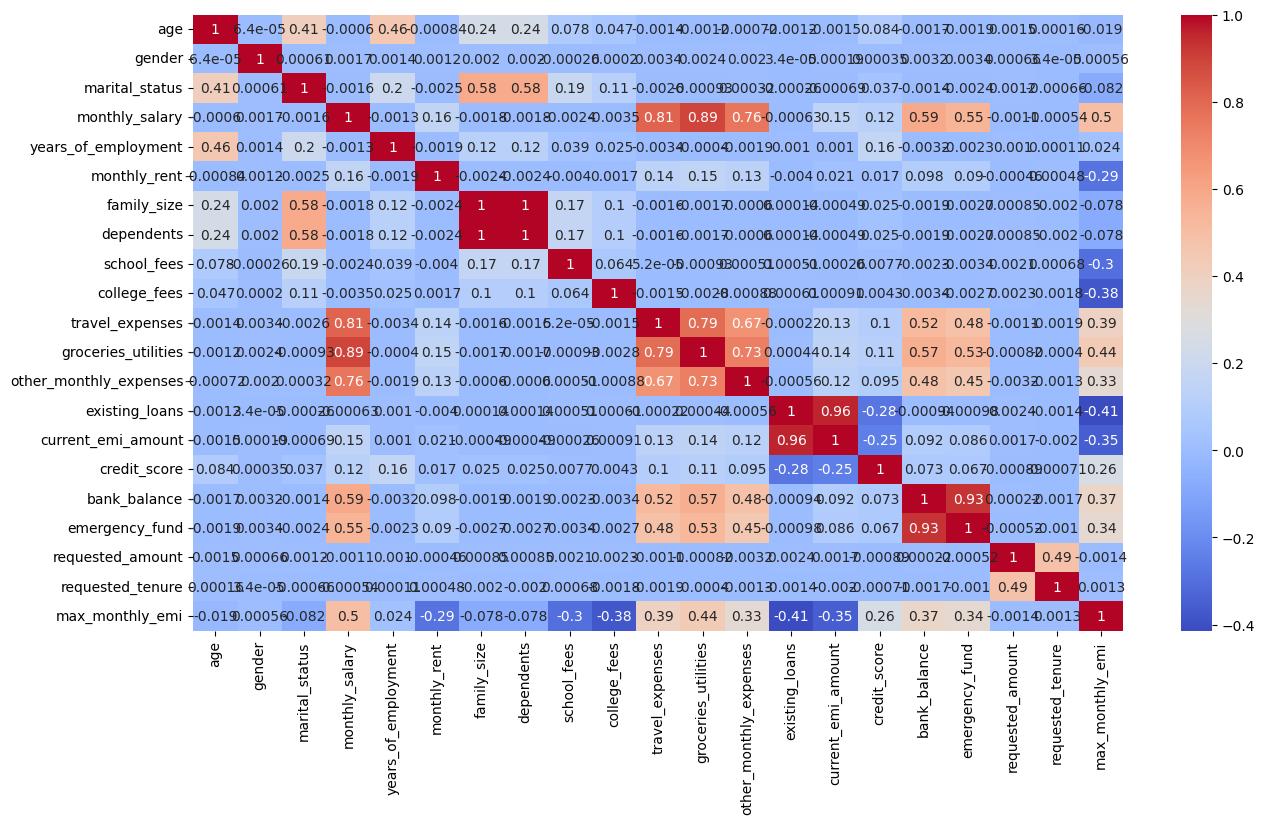

In [199]:
plt.figure(figsize=(15,8))
sns.heatmap(emi_pred_new.select_dtypes(["float64", "int64"]).corr(method='spearman'), annot=True, cmap='coolwarm');

In [200]:
anova_test_columns=[
    'age', 'monthly_salary', 'years_of_employment', 'monthly_rent',
    'family_size', 'dependents', 'school_fees', 'college_fees',
    'travel_expenses', 'groceries_utilities', 'other_monthly_expenses',
    'current_emi_amount', 'credit_score', 'bank_balance',
    'emergency_fund', 'requested_amount', 'requested_tenure', 'max_monthly_emi']

In [201]:
emi_pred_new[anova_test_columns]

,age,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,groceries_utilities,other_monthly_expenses,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,max_monthly_emi
0,38,82600,0.9,20000.0,3,2,0.0,0.0,7200.0,19500.0,13200.0,23700.0,660.0,303200.0,70200.0,850000.0,15,500.0
1,38,21500,7.0,0.0,2,1,5100.0,0.0,1400.0,5400.0,3500.0,4100.0,714.0,92500.0,26900.0,128000.0,19,700.0
2,38,86100,5.8,0.0,4,3,0.0,0.0,10200.0,19400.0,6000.0,0.0,650.0,672100.0,324200.0,306000.0,16,27775.0
3,58,66800,2.2,0.0,5,4,11400.0,0.0,6200.0,11900.0,7900.0,0.0,685.0,440900.0,178100.0,304000.0,83,16170.0
4,48,57300,3.4,0.0,4,3,9400.0,21300.0,3600.0,16200.0,8100.0,0.0,770.0,97300.0,28200.0,252000.0,7,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27,32400,5.0,10400.0,4,3,2800.0,7000.0,2200.0,4900.0,6100.0,0.0,649.0,62000.0,32600.0,506000.0,47,500.0
404796,38,49200,1.9,0.0,5,4,14000.0,0.0,2600.0,13600.0,8600.0,0.0,712.0,142200.0,38100.0,708000.0,33,5200.0
404797,32,25700,3.2,6300.0,1,0,0.0,0.0,2000.0,4600.0,2500.0,0.0,676.0,191600.0,39700.0,93000.0,21,5665.0
404798,48,47200,3.0,0.0,4,3,0.0,0.0,7000.0,8900.0,7200.0,0.0,784.0,170400.0,45600.0,144000.0,36,14460.0


#### Anova test against numeric columns vs emai_eligibility
- Anova test H0: There is no significant difference in the means of the numeric feature across different levels of `emi_eligibility`.
- Anova test H1: There is a significant difference in the means of the numeric feature across different levels of `emi_eligibility`.
- ALPHA = 0.05

In [202]:
from scipy.stats import f_oneway
emi_pred_new[anova_test_columns]

,age,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,groceries_utilities,other_monthly_expenses,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,max_monthly_emi
0,38,82600,0.9,20000.0,3,2,0.0,0.0,7200.0,19500.0,13200.0,23700.0,660.0,303200.0,70200.0,850000.0,15,500.0
1,38,21500,7.0,0.0,2,1,5100.0,0.0,1400.0,5400.0,3500.0,4100.0,714.0,92500.0,26900.0,128000.0,19,700.0
2,38,86100,5.8,0.0,4,3,0.0,0.0,10200.0,19400.0,6000.0,0.0,650.0,672100.0,324200.0,306000.0,16,27775.0
3,58,66800,2.2,0.0,5,4,11400.0,0.0,6200.0,11900.0,7900.0,0.0,685.0,440900.0,178100.0,304000.0,83,16170.0
4,48,57300,3.4,0.0,4,3,9400.0,21300.0,3600.0,16200.0,8100.0,0.0,770.0,97300.0,28200.0,252000.0,7,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27,32400,5.0,10400.0,4,3,2800.0,7000.0,2200.0,4900.0,6100.0,0.0,649.0,62000.0,32600.0,506000.0,47,500.0
404796,38,49200,1.9,0.0,5,4,14000.0,0.0,2600.0,13600.0,8600.0,0.0,712.0,142200.0,38100.0,708000.0,33,5200.0
404797,32,25700,3.2,6300.0,1,0,0.0,0.0,2000.0,4600.0,2500.0,0.0,676.0,191600.0,39700.0,93000.0,21,5665.0
404798,48,47200,3.0,0.0,4,3,0.0,0.0,7000.0,8900.0,7200.0,0.0,784.0,170400.0,45600.0,144000.0,36,14460.0


In [203]:
anova_test_columns

['age',
 'monthly_salary',
 'years_of_employment',
 'monthly_rent',
 'family_size',
 'dependents',
 'school_fees',
 'college_fees',
 'travel_expenses',
 'groceries_utilities',
 'other_monthly_expenses',
 'current_emi_amount',
 'credit_score',
 'bank_balance',
 'emergency_fund',
 'requested_amount',
 'requested_tenure',
 'max_monthly_emi']

In [204]:
emi_pred_new["emi_eligibility"].unique()

array(['Not_Eligible', 'Eligible', 'High_Risk'], dtype=object)

In [205]:
check1=emi_pred_new[emi_pred_new["emi_eligibility"]=="Eligible"]["age"]
check2=emi_pred_new[emi_pred_new["emi_eligibility"]=="Not_Eligible"]["age"]
check3=emi_pred_new[emi_pred_new["emi_eligibility"]=="High_Risk"]["age"]


In [206]:
f_oneway(check1, check2, check3)

F_onewayResult(statistic=np.float64(0.604400003988056), pvalue=np.float64(0.5464026603513061))

In [207]:
# ddfining anova test function

from scipy.stats import f_oneway

def anova_test(column: list, data=emi_pred_new, target='emi_eligibility'):
    """Performs ANOVA test for each column against the target categorical variable."""
    anova_results = []
    for col in column:
        if col != target:
            groups = []
            for level in data['emi_eligibility'].unique():
                group = data[data['emi_eligibility'] == level][col].dropna()
                groups.append(group)
            f_stat, p_value = f_oneway(*groups)
            anova_results.append({
                'Feature': col,
                'F-statistic': f_stat,
                'p-value': p_value
            })
    return pd.DataFrame(anova_results).apply(lambda row: 'Significant' if row['p-value'] < 0.05 else 'Not Significant', axis=1).to_frame(name='Significance').join(pd.DataFrame(anova_results))

In [208]:
anova_test_results=anova_test(anova_test_columns, data=emi_pred_new)

In [209]:
anova_test_results.sort_values(by="F-statistic", ascending=False)

,Significance,Feature,F-statistic,p-value
17,Significant,max_monthly_emi,110796.845004,0.000000e+00
15,Significant,requested_amount,21836.791742,0.000000e+00
9,Significant,groceries_utilities,18732.899994,0.000000e+00
13,Significant,bank_balance,15518.531750,0.000000e+00
8,Significant,travel_expenses,15267.149115,0.000000e+00
14,Significant,emergency_fund,12495.532055,0.000000e+00
10,Significant,other_monthly_expenses,11275.164068,0.000000e+00
1,Significant,monthly_salary,10890.919506,0.000000e+00
7,Significant,college_fees,6357.982678,0.000000e+00
11,Significant,current_emi_amount,5032.974123,0.000000e+00


- If p-value < ALPHA, we reject H0 and accept H1, indicating that the numeric feature has a significant effect on `emi_eligibility`.
- `age` columns is insignificant with `emi_eligibility` as p-value > 0.05
- All other numeric columns are significant with `emi_eligibility` as p-value < 0.05
- However, some columns are more significant than others based on the F-statistic value. Higher F-statistic values indicate a stronger effect of the numeric feature on `emi_eligibility`.
- columns like `max_monthly_emi`, `requested_amount`, `bank_balance`, `credit_score` have higher F-statistic values, suggesting they are more influential in determining EMI eligibility compared to columns like `age` and `dependents`.

In [210]:
emi_pred_new.columns

Index(['age', 'gender', 'marital_status', 'education', 'monthly_salary',
       'employment_type', 'years_of_employment', 'company_type', 'house_type',
       'monthly_rent', 'family_size', 'dependents', 'school_fees',
       'college_fees', 'travel_expenses', 'groceries_utilities',
       'other_monthly_expenses', 'existing_loans', 'current_emi_amount',
       'credit_score', 'bank_balance', 'emergency_fund', 'emi_scenario',
       'requested_amount', 'requested_tenure', 'emi_eligibility',
       'max_monthly_emi'],
      dtype='object')

In [211]:
fixed_expenses=['school_fees', 'college_fees', 'current_emi_amount']

In [212]:
otherexpenses_col=['travel_expenses', 'groceries_utilities','other_monthly_expenses'] 

In [213]:
emi_pred_new["Total_Fixed_expenses"]=emi_pred_new[fixed_expenses].sum(axis=1)
emi_pred_new["Total_Other_expenses"]=emi_pred_new[otherexpenses_col].sum(axis=1)

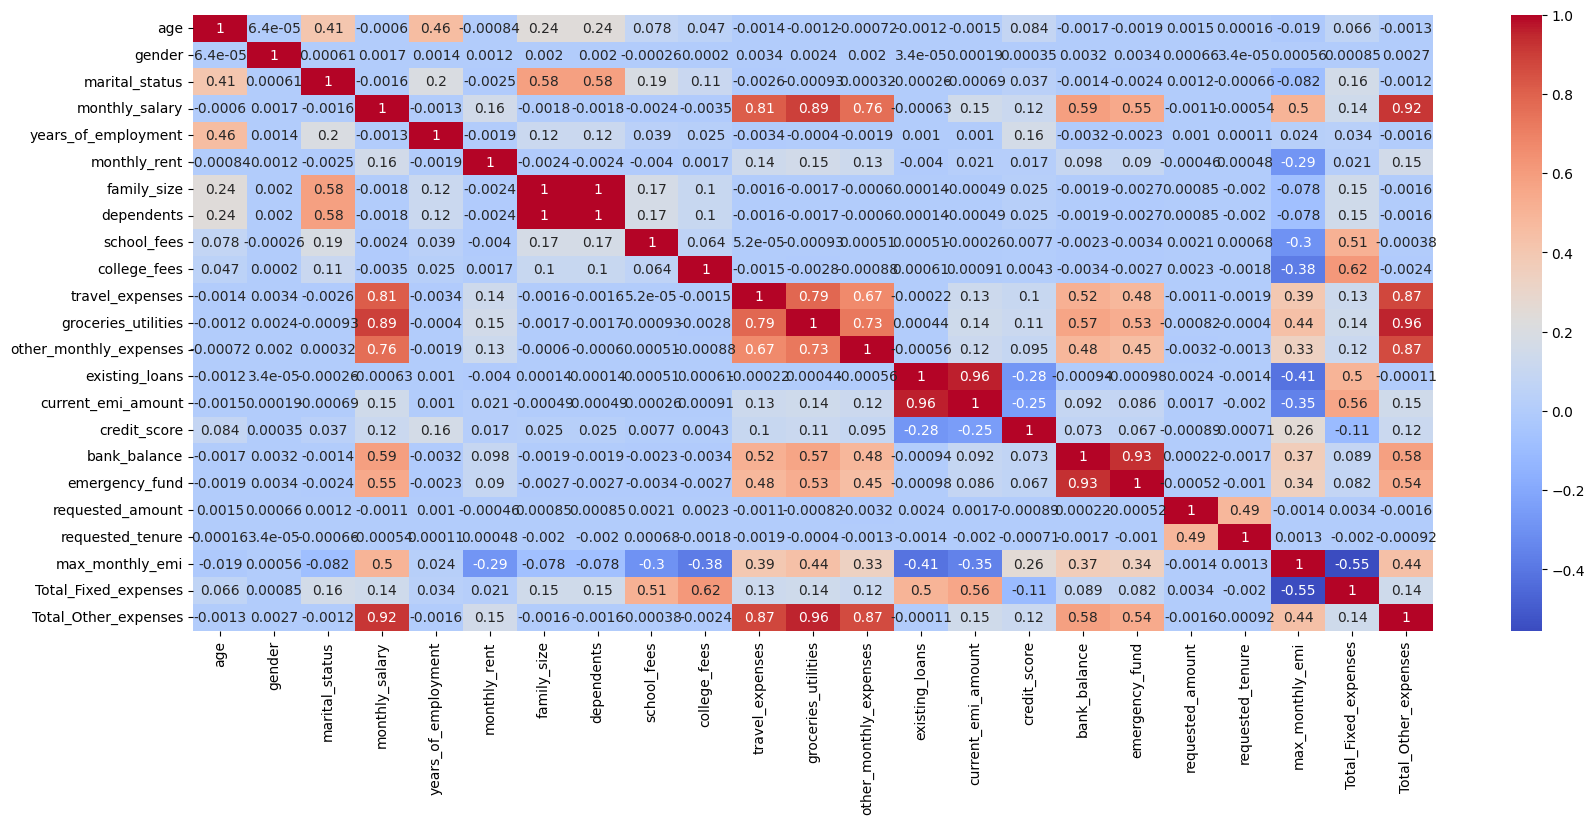

In [214]:
plt.figure(figsize=(20,8))
sns.heatmap(emi_pred_new.select_dtypes(["float64", "int64"]).corr(method='spearman'), annot=True, cmap='coolwarm');

In [215]:
emi_pred_new['emi_eligibility'].value_counts()

emi_eligibility
Not_Eligible    312868
Eligible         74444
High_Risk        17488
Name: count, dtype: int64

In [216]:
emi_pred_new[emi_pred_new["emi_eligibility"]=="Not_Eligible"].describe()

,age,gender,marital_status,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,max_monthly_emi,Total_Fixed_expenses,Total_Other_expenses
count,312868.000000,312868.000000,312868.000000,312868.000000,312868.000000,311005.000000,312868.000000,312868.000000,312868.000000,312868.000000,...,312868.000000,312868.000000,310984.000000,3.109880e+05,311065.000000,3.128680e+05,312868.000000,312868.000000,312868.000000,312868.000000
mean,38.883031,0.600154,0.768903,54263.261548,5.303492,6318.829440,2.964282,1.964282,5019.975197,4758.577100,...,0.466593,5133.364550,694.067206,2.155090e+05,86250.736020,4.282506e+05,28.939796,4301.704766,14911.916847,23490.550008
std,9.293651,0.489867,0.421535,41805.487273,6.055228,8570.799142,1.059597,1.059597,5148.669717,7773.647729,...,0.498884,7084.440581,88.055583,1.626099e+05,72196.762026,3.612457e+05,18.449736,5043.454275,11609.102026,12408.464893
min,26.000000,0.000000,0.000000,3967.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.100000e+03,1400.000000,1.000000e+04,3.000000,500.000000,0.000000,3300.000000
25%,32.000000,0.000000,1.000000,32400.000000,1.200000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,647.000000,9.400000e+04,34500.000000,1.560000e+05,15.000000,500.000000,6100.000000,14400.000000
50%,38.000000,1.000000,1.000000,46900.000000,3.100000,0.000000,3.000000,2.000000,3900.000000,0.000000,...,0.000000,0.000000,694.000000,1.755000e+05,66400.000000,2.880000e+05,24.000000,2464.000000,13100.000000,21000.000000
75%,48.000000,1.000000,1.000000,65600.000000,7.100000,11300.000000,4.000000,3.000000,9700.000000,9200.000000,...,1.000000,9000.000000,740.000000,2.950000e+05,116300.000000,6.300000e+05,40.000000,6283.200000,22300.000000,29800.000000
max,59.000000,1.000000,1.000000,499970.000000,36.000000,69200.000000,5.000000,4.000000,15000.000000,25000.000000,...,1.000000,56300.000000,1200.000000,1.532400e+06,891500.000000,1.500000e+06,84.000000,62073.000000,81700.000000,128700.000000


In [217]:
emi_pred_new[emi_pred_new["emi_eligibility"]=="Eligible"].describe()

,age,gender,marital_status,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,max_monthly_emi,Total_Fixed_expenses,Total_Other_expenses
count,74444.000000,74444.000000,74444.000000,74444.000000,74444.000000,73998.000000,74444.000000,74444.000000,74444.000000,74444.000000,...,74444.000000,74444.000000,73998.000000,7.399200e+04,74006.000000,7.444400e+04,74444.000000,74444.000000,74444.000000,74444.000000
mean,38.842163,0.600169,0.731060,78981.596193,5.578643,4066.156747,2.858672,1.858672,3253.687335,1689.408146,...,0.157716,2405.848692,725.771670,3.393915e+05,135875.753317,1.553612e+05,29.649871,15911.956710,7348.944173,33512.289775
std,9.329577,0.489867,0.443412,44002.387573,6.139858,8684.120315,1.124015,1.124015,4482.187248,4775.348757,...,0.364477,6390.729543,85.869459,2.219279e+05,100613.343736,1.535395e+05,16.602255,9551.455633,9072.049594,14892.215911
min,26.000000,0.000000,0.000000,4551.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.070000e+04,2300.000000,1.000000e+04,3.000000,694.400000,0.000000,4300.000000
25%,32.000000,0.000000,0.000000,53300.000000,1.400000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,681.000000,1.684750e+05,61000.000000,6.000000e+04,18.000000,8904.000000,0.000000,22500.000000
50%,38.000000,1.000000,1.000000,72800.000000,3.400000,0.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,726.000000,2.970000e+05,111500.000000,1.110000e+05,25.000000,13840.000000,4600.000000,31200.000000
75%,48.000000,1.000000,1.000000,96100.000000,7.500000,0.000000,4.000000,3.000000,6200.000000,0.000000,...,0.000000,0.000000,772.000000,4.652000e+05,184500.000000,1.930000e+05,38.000000,20760.000000,11900.000000,42000.000000
max,59.000000,1.000000,1.000000,499761.000000,36.000000,80000.000000,5.000000,4.000000,15000.000000,25000.000000,...,1.000000,54300.000000,1200.000000,1.717300e+06,890600.000000,1.499000e+06,84.000000,91040.400000,74000.000000,132300.000000


In [218]:
emi_pred_new[emi_pred_new["emi_eligibility"]=="High_Risk"].describe()

,age,gender,marital_status,monthly_salary,years_of_employment,monthly_rent,family_size,dependents,school_fees,college_fees,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,max_monthly_emi,Total_Fixed_expenses,Total_Other_expenses
count,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17371.000000,17488.000000,17488.000000,17488.000000,17488.000000,...,17488.000000,17488.000000,17398.000000,1.738000e+04,17378.000000,1.748800e+04,17488.000000,17488.000000,17488.000000,17488.000000
mean,38.891011,0.600526,0.734732,70300.778305,5.534652,4555.886880,2.861619,1.861619,3386.384950,1798.187328,...,0.220151,3088.111848,716.236292,2.941882e+05,118506.266544,2.613582e+05,30.242909,11864.746149,8272.684126,29930.763952
std,9.370567,0.489804,0.441488,42445.180905,6.220995,8775.932251,1.118146,1.118146,4561.107863,4910.758887,...,0.414360,6782.424999,84.982559,1.968337e+05,89275.288726,2.336419e+05,17.829364,7281.005210,9347.402213,13702.609989
min,26.000000,0.000000,0.000000,5028.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.500000e+03,3100.000000,1.000000e+04,3.000000,500.000000,0.000000,4100.000000
25%,32.000000,0.000000,0.000000,46900.000000,1.300000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,671.000000,1.430000e+05,52100.000000,1.110000e+05,17.000000,6655.000000,0.000000,19900.000000
50%,38.000000,1.000000,1.000000,63800.000000,3.300000,0.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,716.000000,2.550000e+05,95700.000000,1.850000e+05,26.000000,10285.000000,6100.000000,27700.000000
75%,48.000000,1.000000,1.000000,84900.000000,7.500000,6550.000000,4.000000,3.000000,6500.000000,0.000000,...,0.000000,0.000000,763.000000,4.040000e+05,162275.000000,3.222500e+05,41.000000,15120.000000,13100.000000,37400.000000
max,59.000000,1.000000,1.000000,495779.000000,36.000000,61100.000000,5.000000,4.000000,15000.000000,25000.000000,...,1.000000,50900.000000,1200.000000,1.500500e+06,724000.000000,1.499000e+06,84.000000,65718.000000,62200.000000,120700.000000


In [219]:
emi_pred_new.isna().sum()

age                          0
gender                       0
marital_status               0
education                 2404
monthly_salary               0
employment_type              0
years_of_employment          0
company_type                 0
house_type                   0
monthly_rent              2426
family_size                  0
dependents                   0
school_fees                  0
college_fees                 0
travel_expenses              0
groceries_utilities          0
other_monthly_expenses       0
existing_loans               0
current_emi_amount           0
credit_score              2420
bank_balance              2440
emergency_fund            2351
emi_scenario                 0
requested_amount             0
requested_tenure             0
emi_eligibility              0
max_monthly_emi              0
Total_Fixed_expenses         0
Total_Other_expenses         0
dtype: int64

In [220]:
target_cols=['emi_eligibility', 'max_monthly_emi']

In [221]:
emi_pred_new.select_dtypes(include=['object']).columns

Index(['education', 'employment_type', 'company_type', 'house_type',
       'emi_scenario', 'emi_eligibility'],
      dtype='object')

In [222]:
from sklearn.preprocessing import OrdinalEncoder
encoding_columns=['education', 'employment_type', 'company_type', 'house_type',
       'emi_scenario', 'emi_eligibility']

encoder=OrdinalEncoder()
emi_pred_new[encoding_columns]=encoder.fit_transform(emi_pred_new[encoding_columns])

In [228]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(emi_pred_new.drop(columns=target_cols, axis=1))



,missing_values,nan
,n_neighbors,5
,weights,'uniform'
,metric,'nan_euclidean'
,copy,True
,add_indicator,False
,keep_empty_features,False


In [ ]:
new_values=imputer.transform(emi_pred_new.drop(columns=target_cols, axis=1))

In [225]:
new_data=pd.DataFrame(new_values, columns=emi_pred_new.drop(columns=target_cols, axis=1).columns)

In [227]:
emi_pred_new

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi,Total_Fixed_expenses,Total_Other_expenses
0,38,0,1,3.0,82600,1.0,0.9,1.0,2.0,20000.0,...,660.0,303200.0,70200.0,3.0,850000.0,15,2.0,500.0,23700.0,39900.0
1,38,0,1,0.0,21500,1.0,7.0,2.0,0.0,0.0,...,714.0,92500.0,26900.0,0.0,128000.0,19,2.0,700.0,9200.0,10300.0
2,38,1,1,3.0,86100,1.0,5.8,4.0,1.0,0.0,...,650.0,672100.0,324200.0,1.0,306000.0,16,0.0,27775.0,0.0,35600.0
3,58,0,1,1.0,66800,1.0,2.2,1.0,1.0,0.0,...,685.0,440900.0,178100.0,4.0,304000.0,83,0.0,16170.0,11400.0,26000.0
4,48,0,1,3.0,57300,1.0,3.4,1.0,0.0,0.0,...,770.0,97300.0,28200.0,2.0,252000.0,7,2.0,500.0,30700.0,27900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27,1,1,0.0,32400,1.0,5.0,0.0,2.0,10400.0,...,649.0,62000.0,32600.0,3.0,506000.0,47,2.0,500.0,9800.0,13200.0
404796,38,1,1,2.0,49200,1.0,1.9,2.0,1.0,0.0,...,712.0,142200.0,38100.0,3.0,708000.0,33,2.0,5200.0,14000.0,24800.0
404797,32,1,0,0.0,25700,1.0,3.2,2.0,2.0,6300.0,...,676.0,191600.0,39700.0,2.0,93000.0,21,1.0,5665.0,0.0,9100.0
404798,48,1,1,0.0,47200,1.0,3.0,2.0,1.0,0.0,...,784.0,170400.0,45600.0,2.0,144000.0,36,0.0,14460.0,0.0,23100.0


In [226]:
new_data

,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,...,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,Total_Fixed_expenses,Total_Other_expenses
0,38.0,0.0,1.0,3.0,82600.0,1.0,0.9,1.0,2.0,20000.0,...,1.0,23700.0,660.0,303200.0,70200.0,3.0,850000.0,15.0,23700.0,39900.0
1,38.0,0.0,1.0,0.0,21500.0,1.0,7.0,2.0,0.0,0.0,...,1.0,4100.0,714.0,92500.0,26900.0,0.0,128000.0,19.0,9200.0,10300.0
2,38.0,1.0,1.0,3.0,86100.0,1.0,5.8,4.0,1.0,0.0,...,0.0,0.0,650.0,672100.0,324200.0,1.0,306000.0,16.0,0.0,35600.0
3,58.0,0.0,1.0,1.0,66800.0,1.0,2.2,1.0,1.0,0.0,...,0.0,0.0,685.0,440900.0,178100.0,4.0,304000.0,83.0,11400.0,26000.0
4,48.0,0.0,1.0,3.0,57300.0,1.0,3.4,1.0,0.0,0.0,...,0.0,0.0,770.0,97300.0,28200.0,2.0,252000.0,7.0,30700.0,27900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404795,27.0,1.0,1.0,0.0,32400.0,1.0,5.0,0.0,2.0,10400.0,...,0.0,0.0,649.0,62000.0,32600.0,3.0,506000.0,47.0,9800.0,13200.0
404796,38.0,1.0,1.0,2.0,49200.0,1.0,1.9,2.0,1.0,0.0,...,0.0,0.0,712.0,142200.0,38100.0,3.0,708000.0,33.0,14000.0,24800.0
404797,32.0,1.0,0.0,0.0,25700.0,1.0,3.2,2.0,2.0,6300.0,...,0.0,0.0,676.0,191600.0,39700.0,2.0,93000.0,21.0,0.0,9100.0
404798,48.0,1.0,1.0,0.0,47200.0,1.0,3.0,2.0,1.0,0.0,...,0.0,0.0,784.0,170400.0,45600.0,2.0,144000.0,36.0,0.0,23100.0
